此脚本详细记载了PDCoV病毒粒子的vRIC-seq数据分析及可视化流程

figure 1 The workflow of virus sequencing
输入：
输出：D:\360MoveData\Users\dgwei\Desktop\文章\Scientific_data-Sunju\最新修改\2024.5.21\scidata-figure1.tif

figure 2
输入：
输出：D:\360MoveData\Users\dgwei\Desktop\文章\Scientific_data-Sunju\最新修改\2024.5.21\scidata-figure1.tif
A, The green and pink bar charts represent the number of reads in the raw and cleaned FASTQ files, respectively.
B, Two sets of biological replicates, with different colors in the pie and bar charts displaying the proportion of sequencing data aligned to the virus genome, host genome (including rRNA), virus-to-host genome and unmapped reads.The proportion of valid chimeric reads in all paired reads. The three colors represent normal pairs,valid chimeric pairs and dropped pairs.Two bar charts represent two sets of biological replicates.
C,Calculate the percentage of cytosine at the junction of chimeric reads, the horizontal axis uses the junction site of all valid chimeric reads as the origin, and statistics are compiled on the percentage of cytosines within the 20 bases before and after the junction site,two colors represent two sets of biological replicates.

figure 3
输入：
输出：
A, Scatter plot showing the correlation for coverage of chimeric reads along the PDCoV genome in two biological replicates (Rep1 and Rep2). R, Pearson correlation coefficient.
B, Scatter plots showing the correlation between two biological replicates for the number of chimeric reads (interaction strength). R, Pearson correlation coefficient
C, Interaction matrix of two biological replicates. In the heatmap, the shade of color represents the strength of viral RNA interactions, and the arcs indicate the positions of interactions within the viral genome. The black dashed lines denote pseudo structural domains.

figure 4
输入：
输出：
A, Distance decay curve of two biological replicates.The horizontal axis represents the distance between interacting RNAs, while the vertical axis represents the number of chimeric reads corresponding to different distances. Two colors represent two sets of biological replicates.
B, Topological domains of genomes of different sizes and their corresponding numbers. The horizontal axis represents the length of the pseudo structural domain, and the vertical axis represents the number of structural domains with different lengths.
C, Pairwise interacting RNA fragments (n=) showed more vRIC-seq signals than the random controls that have the same spanning distance (n=).
D, The minimum free energy of duplexes (n = 30) detected by vRIC-seq were significantly lower than the shuffled control.

figure 5 Whole genome secondary structure of PDCoV
输入：
输出：

Interaction matrix of two biological replicates. In the heatmap, the shade of color represents the strength of viral RNA interactions, and the arcs indicate the positions of interactions within the viral genome. The black dashed lines denote pseudo structural domains.

In [1]:
#bulk RNA-seq & Nanopore
#基于转录组测序技术分析冠状病毒基因组
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%matplotlib inline可以在Notebook中直接显示图形输出，%load_ext autoreload和%autoreload 2用于自动重新加载模块

In [6]:
#bulk RNA-seq
import os
os.chdir("D:/360MoveData/Users/dgwei/Desktop/工作/BASIC/三维数据分析流程/原始数据处理/PEDV/virion/")
from plotly.offline import plot
from IPython.display import IFrame
import pandas as pd
import numpy as np
import shutil#os模块的补充，提供了复制、移动、删除、压缩、解压等操作
from tabulate import tabulate#打印漂亮的表格数据
import matplotlib.pyplot as plt
from copy import copy
from matplotlib import colors
from scipy.signal import find_peaks

In [7]:
# 获取所有可用的色彩映射
all_colormaps = plt.colormaps()
#all_colormaps

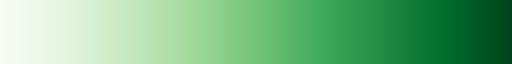

In [8]:
# palette = copy(plt.cm.viridis)
palette1 = copy(plt.cm.Greens)
palette1.set_over('magenta', 1.0)
palette1.set_under('black', 1.0)
palette1.set_bad('magenta', 1.0)
palette1

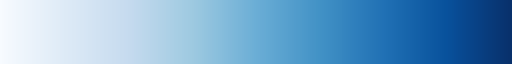

In [9]:
# palette = copy(plt.cm.viridis)
palette2 = copy(plt.cm.Blues)
palette2.set_over('magenta', 1.0)
palette2.set_under('black', 1.0)
palette2.set_bad('magenta', 1.0)
palette2

In [10]:
largedels_mgi1 = pd.read_csv('PEDV-1_in_Virion.5nt.raw.matrix', names=['j5', 'j3', 'count'], sep='\t')
largedels_mgi2 = pd.read_csv('PEDV-2_in_Virion.5nt.raw.matrix', names=['j5', 'j3', 'count'], sep='\t')

In [11]:
largedels_mgi1['count'].sum(axis=0)

12397843.0

In [12]:
largedels_mgi2['count'].sum(axis=0)

10850375.0

In [13]:
tilesize = 100
largedels_mgi1['j5_tile'] = ((largedels_mgi1['j5'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_mgi1['j3_tile'] = ((largedels_mgi1['j3'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_mgi2['j5_tile'] = ((largedels_mgi2['j5'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_mgi2['j3_tile'] = ((largedels_mgi2['j3'] // tilesize) * tilesize + tilesize/2).astype(int)

In [14]:
tiled_counts1 = largedels_mgi1.groupby(['j5_tile', 'j3_tile']).agg({'count': 'sum'}).reset_index()
tiled_counts2 = largedels_mgi2.groupby(['j5_tile', 'j3_tile']).agg({'count': 'sum'}).reset_index()

In [15]:
trv1 = tiled_counts1.pivot(index='j5_tile', columns='j3_tile', values=['count']).fillna(0).astype(int)
trv2 = tiled_counts2.pivot(index='j5_tile', columns='j3_tile', values=['count']).fillna(0).astype(int)

In [16]:
juncdensity1 = np.log10(trv1+1).T.values
juncdensity2 = np.log10(trv2+1).values
juncdensity1[np.triu_indices(juncdensity1.shape[0],k=1, m=None)] = np.nan
juncdensity2[np.tril_indices(juncdensity2.shape[0],k=1, m=None)] = np.nan

In [18]:
domain = pd.read_csv('PEDV.domains-600.bedpe', names=['chr1', 'x1', 'x2','chr2','y1','y2','name','score','strand1','strand2'], sep='\t',skiprows=1)
a,b = domain.shape

In [21]:
COLORMAX = 5
NUMBINS = juncdensity1.shape[0]
NUMBINS

281

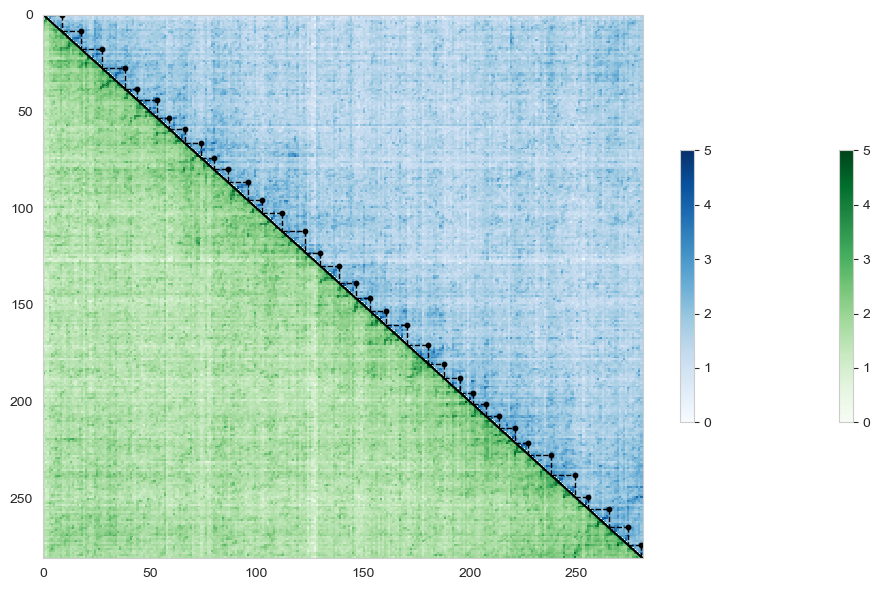

In [24]:
plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('white')
cbo1 = plt.pcolor(juncdensity1, cmap=palette1,norm=colors.Normalize(vmin=0, vmax=COLORMAX),rasterized=True)
cbo2 = plt.pcolor(juncdensity2, cmap=palette2,norm=colors.Normalize(vmin=0, vmax=COLORMAX),rasterized=True)
plt.colorbar(cbo1,shrink=.5)
plt.colorbar(cbo2,shrink=.5)
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
rows, cols = juncdensity1.shape
# plt.plot([cols,0], [rows, 0], color='black',linestyle='dashed')
plt.plot([cols,0], [rows, 0], color='black')
# plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0), useMathText=True)

# 在交互矩阵上添加split domain
for i in range(a):
    s = domain.iloc[i,1]/100
    e = domain.iloc[i,2]/100
    plt.scatter(e,s, c='black', marker='o',s=10)
    plt.axhline(y=s, color='black', linestyle='--', linewidth=1, xmin=s/cols, xmax=e/cols)
    plt.axvline(x=e, color='black', linestyle='--', linewidth=1, ymin=(281-s)/rows, ymax=(281-e)/rows)

plt.tight_layout()
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/PEDV_interactor_matrix.png')

vRIC-seq覆盖度两组样本相关性

In [22]:
import numpy as np
import xlrd
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
file_dir="D:/360MoveData/Users/dgwei/Desktop/文章/Scientific_data-Sunju/result/"
# file_dir="D:/360MoveData/Users/dgwei/Desktop/"
def get_matrix_npz(M1,M2):
    '''
    transform a three tuple into a matrix
    '''
    S1 = sparse.coo_matrix((M1['value'],(np.asarray(M1['S'], dtype=int),np.asarray(M1['E'], dtype=int)))).toarray()
    S2 = sparse.coo_matrix((M2['value'],(np.asarray(M2['E'], dtype=int),np.asarray(M2['S'], dtype=int)))).toarray()
    matrix = np.zeros((max(S2.shape),max(S1.shape)))
    matrix[np.nonzero(S1)] = S1[np.nonzero(S1)]
    matrix[np.nonzero(S2)] = S2[np.nonzero(S2)]
    return matrix

In [24]:
Sars1 = np.loadtxt(file_dir +'27_in_Virion.5nt.none.matrix', usecols=[0,1,2], dtype=[('S','<i4'),('E','<i4'),('value','<f8')])
res = 5
Sars1['S'] = Sars1['S'] / res
Sars1['E'] = Sars1['E'] / res
ma_Sars1 = get_matrix_npz(Sars1,Sars1)

In [27]:
Sars2 = np.loadtxt(file_dir +'30_in_Virion.5nt.none.matrix', usecols=[0,1,2], dtype=[('S','<i4'),('E','<i4'),('value','<f8')])
res = 5
Sars2['S'] = Sars2['S'] / res
Sars2['E'] = Sars2['E'] / res
ma_Sars2 = get_matrix_npz(Sars2,Sars2)

In [28]:
cum_pdcov1 = ma_Sars1.sum(axis=1)
cum_pdcov2 = ma_Sars2.sum(axis=1)

In [29]:
cor = np.corrcoef(np.log10(cum_pdcov1+1),np.log10(cum_pdcov2+1))[0,1]
cor

0.9793749304916877

In [30]:
max(np.log2(cum_pdcov1+1))

15.254622680959708

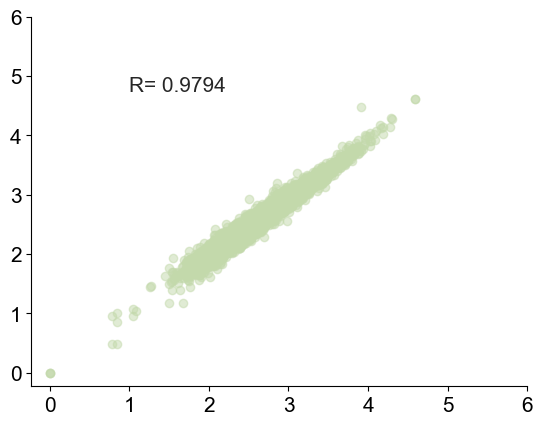

In [32]:
plt.figure()
# plt.scatter(df['coverage1'],df['coverage1'],color='#C3D9AB',alpha=0.5)
plt.scatter(np.log10(cum_pdcov1+1),np.log10(cum_pdcov2+1),color='#C3D9AB',alpha=0.5)

plt.xticks(range(0, 7, 1))
plt.yticks(range(0, 7, 1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(1, 5, f'R= {cor:.4f}', ha='left', va='top',fontsize=15)

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.rcParams['xtick.color']="b"
# plt.rcParams['ytick.color']="b"
# 设置 x 轴刻度线标记
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True,colors='black')
# 设置 y 轴刻度线标记
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,colors='black')
# plt.axvline(x=0, linestyle='dashed', color='#3888C1',alpha=0.5)
# plt.legend(loc='upper right',fontsize="xx-large",frameon=False)#frameon去除边框
x_axis = plt.gca().spines['bottom']
y_axis = plt.gca().spines['left']

# 设置 x 轴和 y 轴的颜色为黑色
x_axis.set_color('black')
y_axis.set_color('black')
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/coverage.pdf')
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/BASIC/三维数据分析流程/原始数据处理/PEDV/virion/coverage.png')
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/文章/Scientific_data-Sunju/文章/coverage.pdf')
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/文章/Scientific_data-Sunju/文章/coverage.png')

重复样本基因交互强度相关性

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ric_fun import get_oe, get_matrix_npz, extract_matrix
# 设置工作目录
import os
os.chdir("D:/360MoveData/Users/dgwei/Desktop/工作/BASIC/三维数据分析流程/原始数据处理/PEDV/virion/")
file_dir = "D:/360MoveData/Users/dgwei/Desktop/工作/BASIC/三维数据分析流程/原始数据处理/PEDV/virion/"

In [26]:
res=5
PDCoV_1 = extract_matrix(file_dir, 'PEDV-1_in_Virion.5nt.raw.matrix', res)[0]
PDCoV_2 = extract_matrix(file_dir, 'PEDV-2_in_Virion.5nt.raw.matrix', res)[0]
lens = min(PDCoV_1.shape[0], PDCoV_2.shape[0])
mask_1 = PDCoV_1 > 0
mask_2 = PDCoV_2 > 0
data_1 = PDCoV_1[mask_1|mask_2]
data_2 = PDCoV_2[mask_1|mask_2]
cof = np.corrcoef(data_1, data_2)[1,0]
cof2 = np.corrcoef(np.log10(PDCoV_1.sum(axis=1)[:lens]+1), np.log10(PDCoV_2.sum(axis=1)[:lens]+1))[1,0]
cof

0.9991058311751689

In [27]:
data_1.shape

(5053232,)

In [28]:
chimericcoverage1=np.log10(PDCoV_1.sum(axis=1)[:lens]+1)
chimericcoverage2=np.log10(PDCoV_2.sum(axis=1)[:lens]+1)

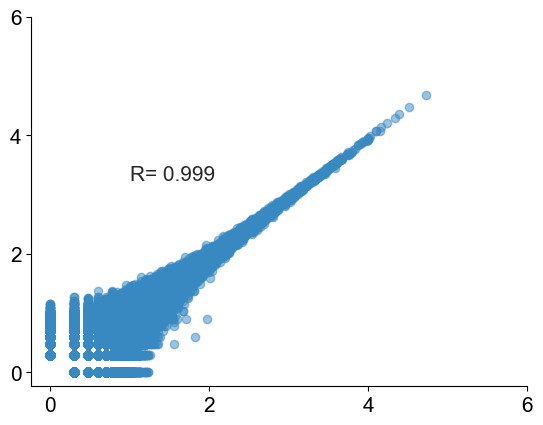

In [31]:
x=data_1+1
y=data_2+1
np.random.seed(0)  # 为了可重复性
indices = np.random.choice(len(x), size=int(len(x)*0.1), replace=False)  # 选取10%的数据点
x_subsample = x[indices]
y_subsample = y[indices]
cof = np.corrcoef(x_subsample, y_subsample)[1,0]
plt.scatter(np.log10(x_subsample),np.log10(y_subsample),color='#3888C1',alpha=0.5)

# plt.scatter(np.log10(data_1+1),np.log10(data_2+1),color='#3888C1',alpha=0.5)
plt.xticks(range(0, 7, 2),fontsize=15)
plt.yticks(range(0, 7, 2),fontsize=15)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# 设置 x 轴刻度线标记
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True,colors='black')
# 设置 y 轴刻度线标记
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,colors='black')
x_axis = plt.gca().spines['bottom']
y_axis = plt.gca().spines['left']
# 设置 x 轴和 y 轴的颜色为黑色
x_axis.set_color('black')
y_axis.set_color('black')
plt.text(1, 3.5, f'R= {cof:.3f}', ha='left', va='top',fontsize=15)
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/interaction.pdf',dpi=200, bbox_inches='tight')
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/PEDV_interaction.png')
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/BASIC/三维数据分析流程/原始数据处理/PEDV/virion/interaction.png')

距离衰减曲线

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ric_fun import extract_matrix
from ric_fun import get_oe, get_matrix_npz
from scipy.stats.mstats import zscore
from brokenaxes import brokenaxes

In [110]:
matrix1 = pd.read_csv('D:/360MoveData/Users/dgwei/Desktop/文章/Scientific_data-Sunju/result/pdcov_in_Virion.5nt.none.matrix', names=['S', 'E', 'value'], sep='\t')
matrix1['dis']=matrix1['E']-matrix1['S']
new_matrix1=matrix1.iloc[:,-2:]
merge_matrix1=new_matrix1.groupby('dis').sum().reset_index()
merge_matrix1['value'] = merge_matrix1['value'].apply(lambda x: (x / 1000))
value_array1 = merge_matrix1['value'].values
max(value_array1)

array([1.637618e+03, 1.144029e+03, 2.068720e+02, ..., 2.000000e-03,
       4.000000e-03, 1.000000e-03])

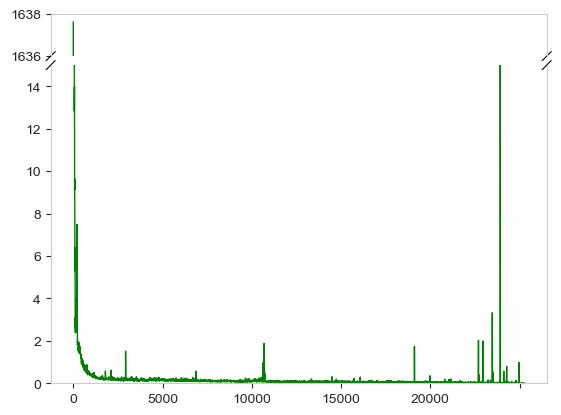

In [149]:
ax = brokenaxes(ylims=((0,15),(1636, 1638)),despine=False, hspace=0.05,d=0.01)
ax.grid(False)
# plt.bar(r1, df['raw'], color='#C3D9AC', width=barWidth, edgecolor='#C3D9AC', label='raw data')
# plt.bar(r2, df['clean'], color='#FDBCAC', width=barWidth, edgecolor='#FDBCAC', label='clean data')
ax.plot(value_array1, label = 'PDCoV-virion',linewidth=1,color="Green")
# ax.plot(value_array2, label = 'PEDV-virion-5nt',linewidth=1,color="Blue",alpha=0.5)
# plt.plot(dis_SARS2_wdh_vero24h_rep2[50:3000], label = 'PDCoV-rep2',linewidth=1)
ax.set_xticks(np.arange(0,5000,1000),np.arange(0,25000,5000))
# ax.set_yticks(fontsize=15)
# ax.legend(loc='upper right',fontsize="large",frameon=False)
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/距离衰减曲线.SARS2PEDV.png')
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/距离衰减曲线.PDCoV.pdf')

圆图显示了嵌合体读数沿PDCoV基因组的分布。内部红色圆圈表示50 nt窗口内腺嘌呤或尿嘧啶的部分，而外部蓝色圆圈表示嵌合阅读片段的覆盖范围，两个圆圈表示两组生物复制子

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ric_fun import extract_matrix
from ric_fun import get_oe, get_matrix_npz
from scipy.stats.mstats import zscore
from brokenaxes import brokenaxes

In [203]:
res=50
PDCoV_1 = extract_matrix(file_dir, '27_in_Virion.50nt.none.matrix', res)[0]
PDCoV_2 = extract_matrix(file_dir, '30_in_Virion.50nt.none.matrix', res)[0]
lens = min(PDCoV_1.shape[0], PDCoV_2.shape[0])
mask_1 = PDCoV_1 > 0
mask_2 = PDCoV_2 > 0
data_1 = PDCoV_1[mask_1|mask_2]
data_2 = PDCoV_2[mask_1|mask_2]
cof = np.corrcoef(data_1, data_2)[1,0]
cof2 = np.corrcoef(np.log10(PDCoV_1.sum(axis=1)[:lens]+1), np.log10(PDCoV_2.sum(axis=1)[:lens]+1))[1,0]

In [204]:
chimericcoverage1=np.log10(PDCoV_1.sum(axis=1)[:lens]+1)
chimericcoverage2=np.log10(PDCoV_2.sum(axis=1)[:lens]+1)

In [201]:
# chimericcoverage1 = chimericcoverage1-chimericcoverage1.mean(axis=0)

In [205]:
n = chimericcoverage1.shape[0]
x_indices = np.arange(1, n + 1)

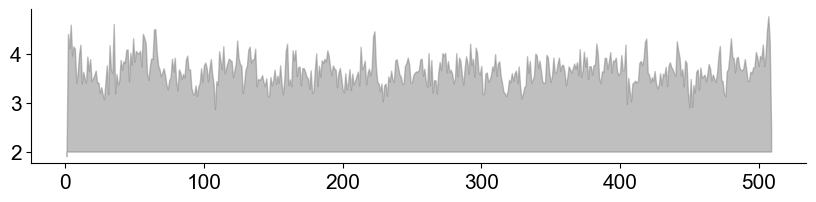

In [213]:
plt.figure(figsize=(10, 2))
plt.fill_between(x_indices,chimericcoverage1, 2, label = 'PDCoV-virion',linewidth=1,color="Gray",alpha=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# 设置 x 轴刻度线标记
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True,colors='black')
# 设置 y 轴刻度线标记
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,colors='black')
x_axis = plt.gca().spines['bottom']
y_axis = plt.gca().spines['left']
# 设置 x 轴和 y 轴的颜色为黑色
x_axis.set_color('black')
y_axis.set_color('black')
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/chimeric.coverage.rep1.pdf')

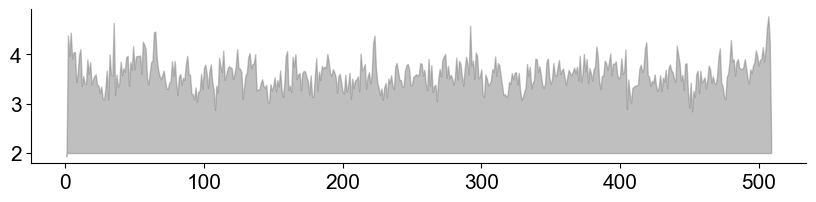

In [214]:
plt.figure(figsize=(10, 2))
plt.fill_between(x_indices,chimericcoverage2, 2, label = 'PDCoV-virion',linewidth=1,color="Gray",alpha=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# 设置 x 轴刻度线标记
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True,colors='black')
# 设置 y 轴刻度线标记
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,colors='black')
x_axis = plt.gca().spines['bottom']
y_axis = plt.gca().spines['left']
# 设置 x 轴和 y 轴的颜色为黑色
x_axis.set_color('black')
y_axis.set_color('black')
plt.savefig('D:/360MoveData/Users/dgwei/Desktop/chimeric.coverage.rep2.pdf')